In [1]:
#Imports
import torchvision.transforms.functional
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import shutil
from genericpath import isdir

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

100%|██████████| 920M/920M [00:44<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [3]:
# paths
source = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1"
destination = "/content/waste_classification"

# copy dataset
shutil.copytree(source, destination)
print(f"Dataset moved to {destination}")

Dataset moved to /content/waste_classification


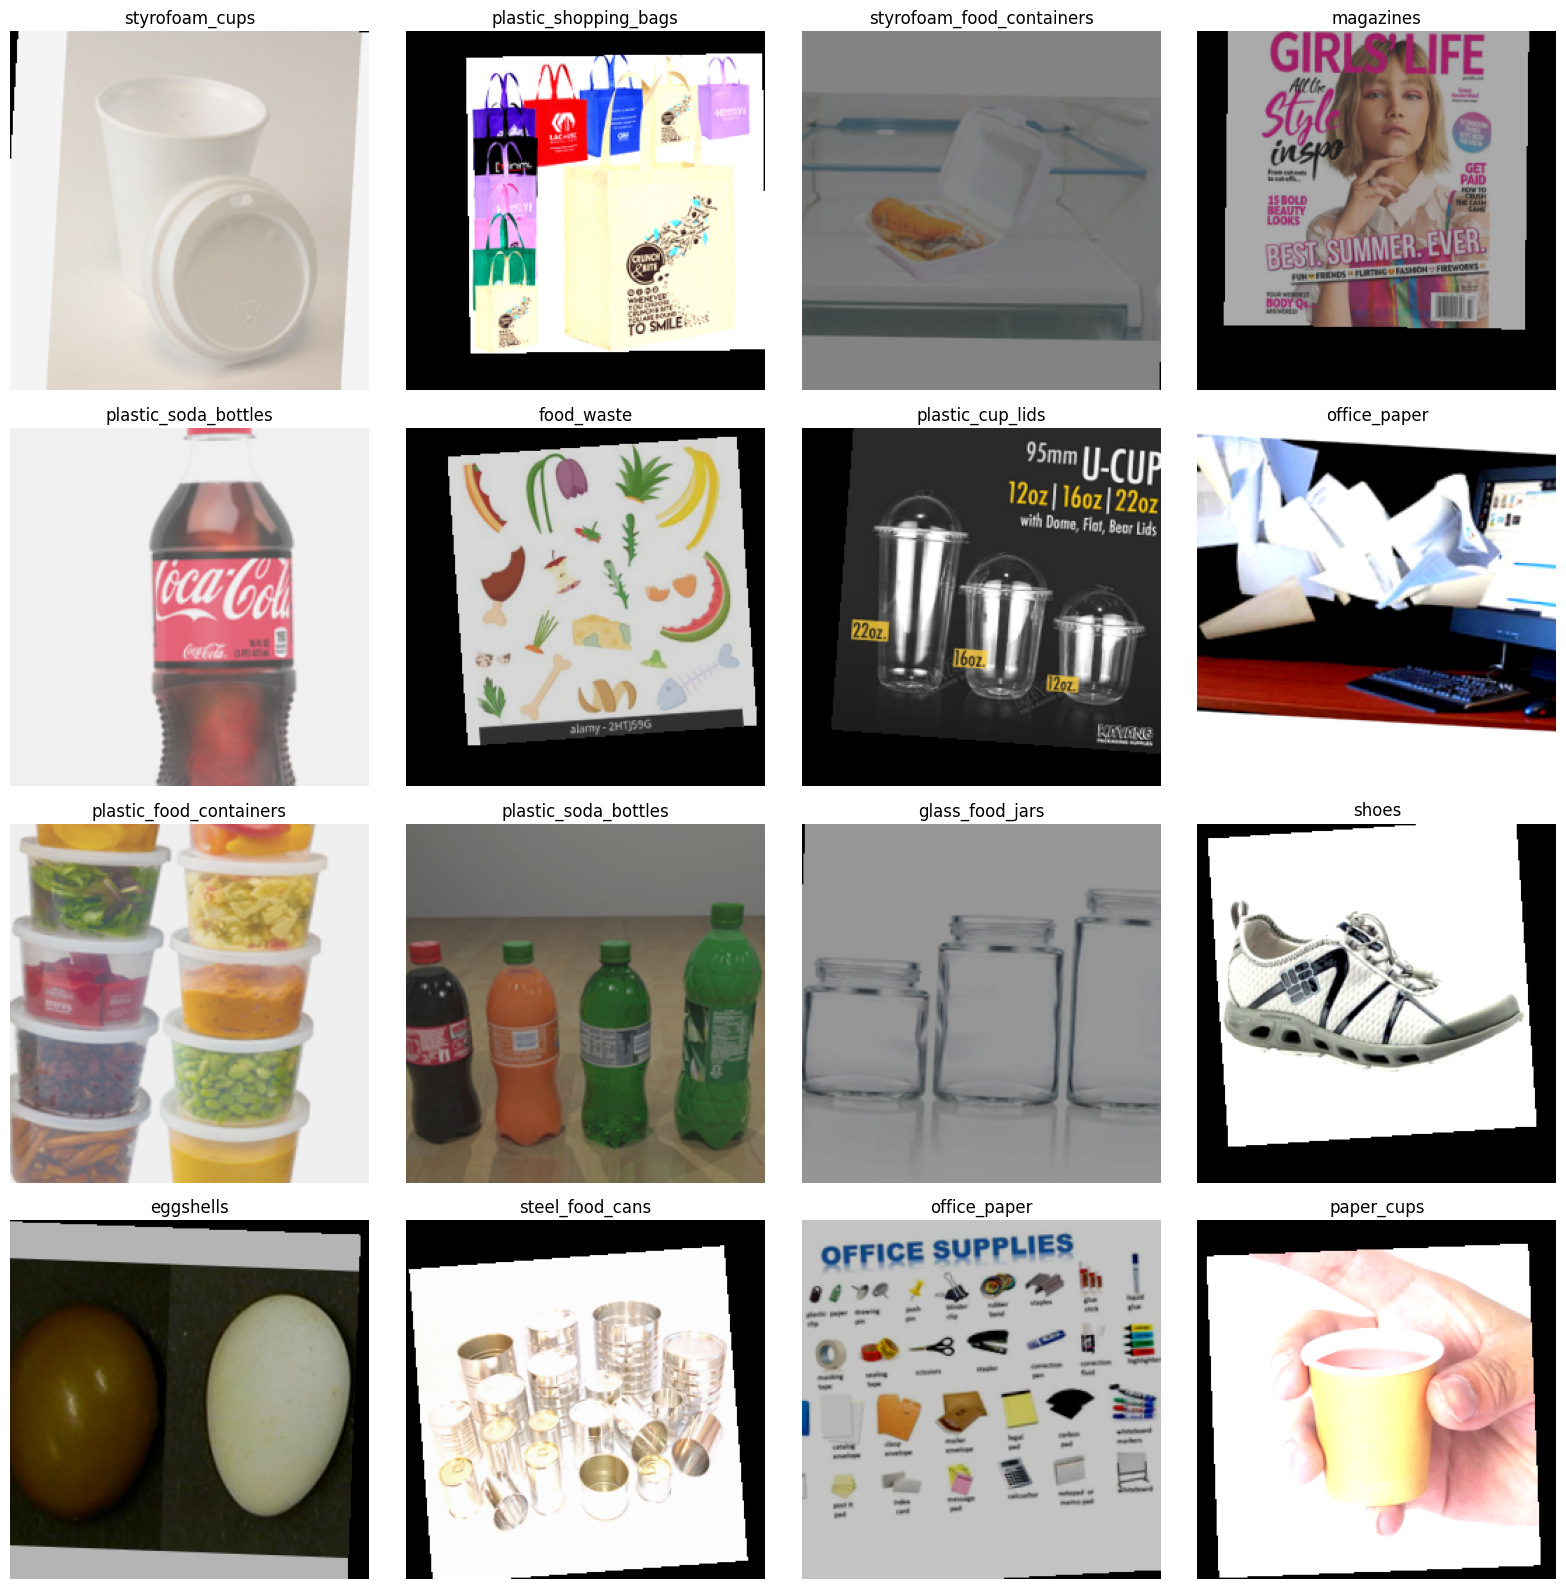

Using Device cuda:0


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 142MB/s]


Epoch 0/49
----------
train Loss : 2.3493 Acc: 0.3546
val Loss : 1.9759 Acc: 0.4730
Epoch 1/49
----------
train Loss : 1.8049 Acc: 0.4909
val Loss : 1.3320 Acc: 0.6130
Epoch 2/49
----------
train Loss : 1.6190 Acc: 0.5447
val Loss : 1.1588 Acc: 0.6633
Epoch 3/49
----------
train Loss : 1.5214 Acc: 0.5758
val Loss : 1.1771 Acc: 0.6443
Epoch 4/49
----------
train Loss : 1.4085 Acc: 0.6008
val Loss : 1.1535 Acc: 0.6630
Epoch 5/49
----------
train Loss : 1.3175 Acc: 0.6304
val Loss : 1.3947 Acc: 0.6133
Epoch 6/49
----------
train Loss : 1.2847 Acc: 0.6380
val Loss : 1.3723 Acc: 0.6157
Epoch 7/49
----------
train Loss : 1.2126 Acc: 0.6526
val Loss : 1.1192 Acc: 0.7100
Epoch 8/49
----------
train Loss : 1.2143 Acc: 0.6572
val Loss : 0.9194 Acc: 0.7330
Epoch 9/49
----------
train Loss : 1.1771 Acc: 0.6669
val Loss : 1.3240 Acc: 0.6197
Epoch 10/49
----------
train Loss : 1.1999 Acc: 0.6629
val Loss : 0.9663 Acc: 0.7323
Epoch 11/49
----------
train Loss : 1.0995 Acc: 0.6812
val Loss : 1.1616 Ac

<ipython-input-4-3d18d39ece04>:260: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/train_loss_best.pt")



-------Classification Report-------

                            precision    recall  f1-score   support

              aerosol_cans       0.94      0.82      0.88       100
        aluminum_food_cans       0.62      0.44      0.51       100
        aluminum_soda_cans       0.89      0.78      0.83       100
           cardboard_boxes       0.71      0.10      0.18       100
       cardboard_packaging       0.51      0.90      0.65       100
                  clothing       0.82      0.84      0.83       100
            coffee_grounds       0.95      0.93      0.94       100
disposable_plastic_cutlery       0.78      0.98      0.87       100
                 eggshells       0.98      0.89      0.93       100
                food_waste       0.91      0.96      0.93       100
    glass_beverage_bottles       0.88      0.84      0.86       100
 glass_cosmetic_containers       0.91      0.80      0.85       100
           glass_food_jars       0.89      0.86      0.87       100
         

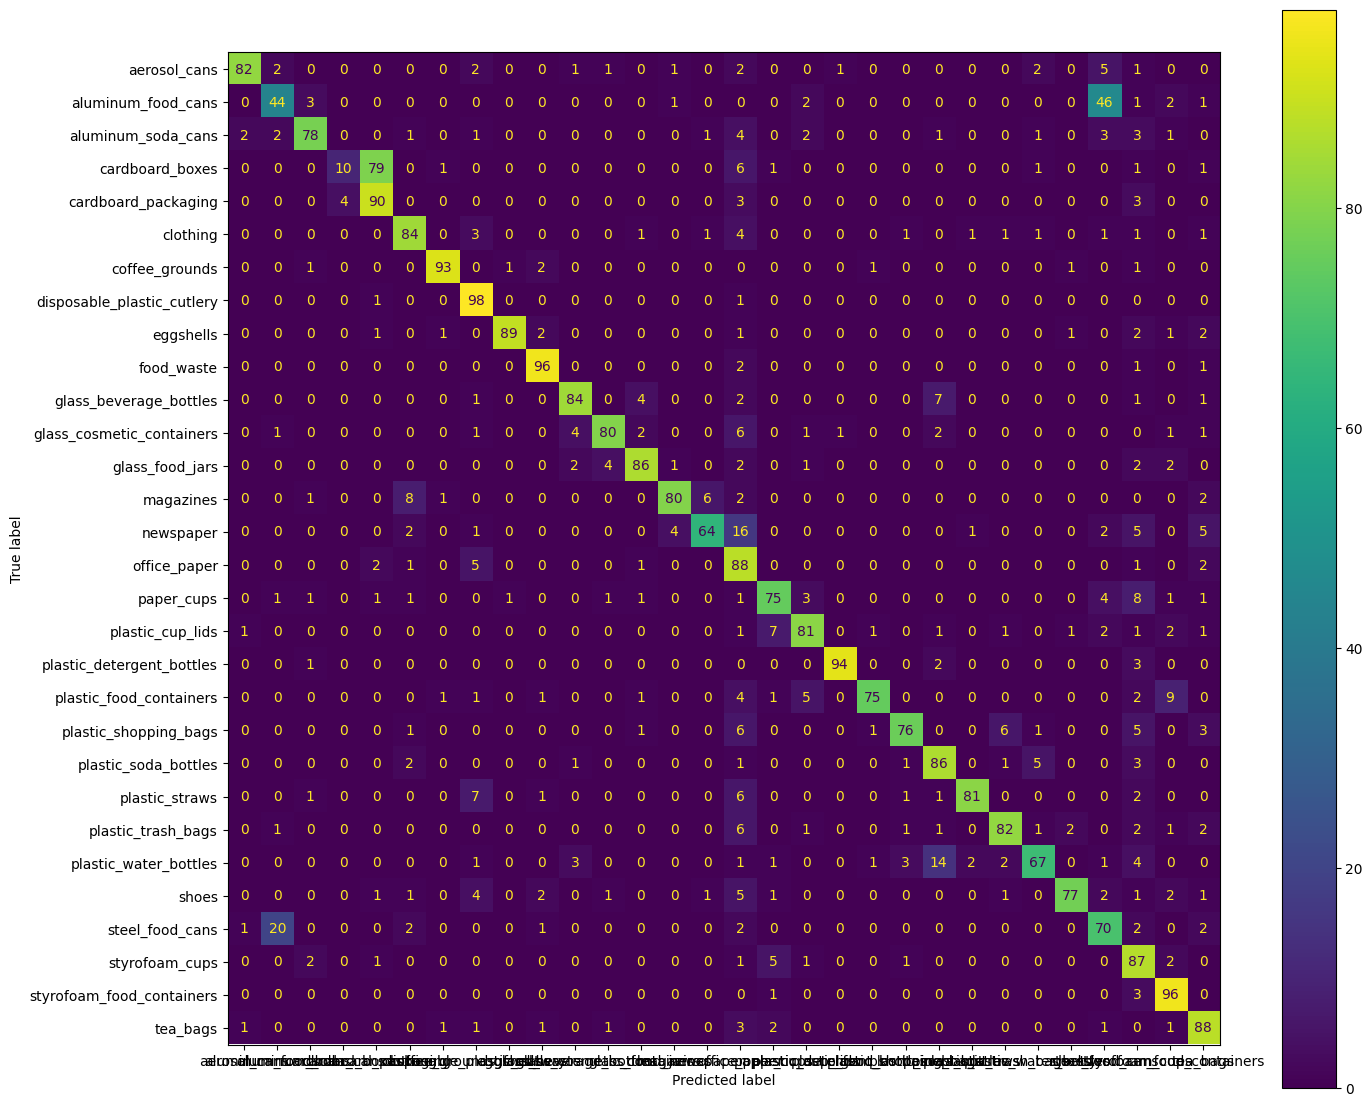

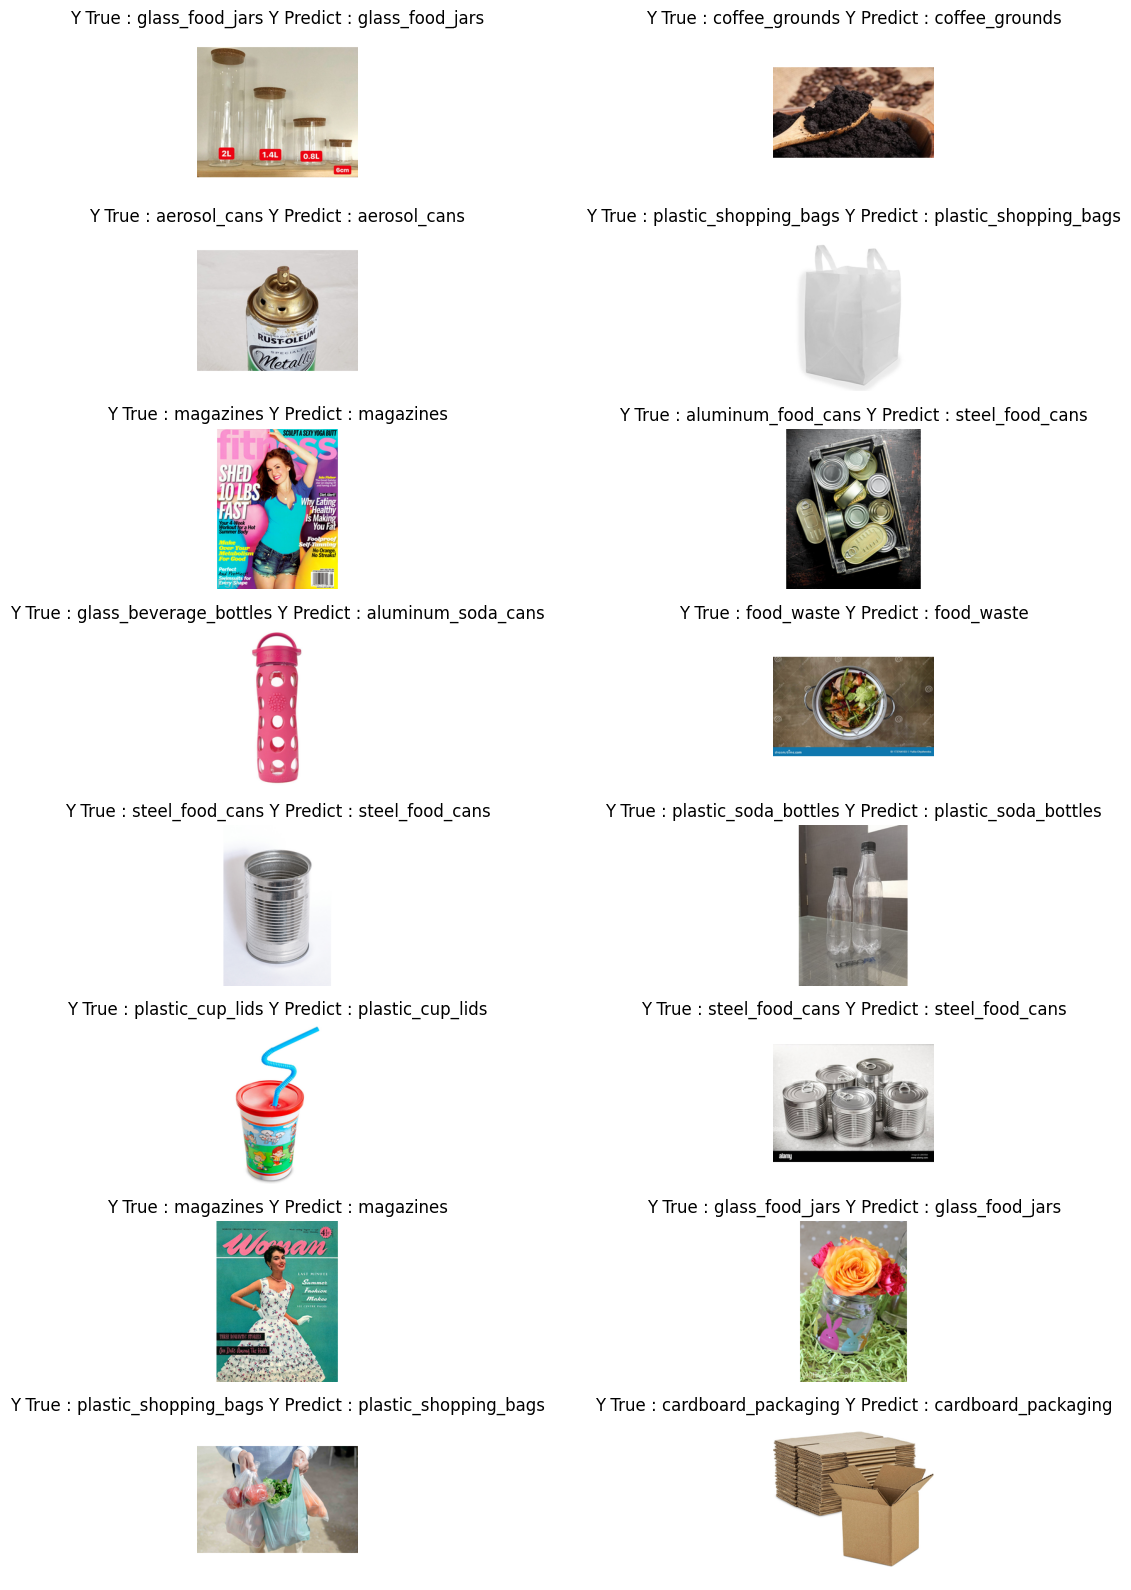

In [4]:
#Prepare Custom Dataset Class
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        data = {
            "image":image,
            "label":label
        }
        return data

#Prepare datasets and dataloaders

train_pil_transform = v2.Compose([

        v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
        v2.RandomAffine(degrees=5, translate=(0.1, 0.1),scale=(0.8,1.3),
                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        v2.Resize(size=(256, 256)),
        v2.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32),
        v2.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ])

val_pil_transform = v2.Compose([
    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_pil_transform = v2.Compose([

    v2.Resize(size=(256, 256)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_transforms = {
    "train":train_pil_transform,
    "val":val_pil_transform,
    "test":test_pil_transform,
}

train_dataset = WasteDataset("/content/waste_classification/images/images","train",
                                            data_transforms["train"])
val_dataset = WasteDataset("/content/waste_classification/images/images","val",
                                            data_transforms["val"])
test_dataset = WasteDataset("/content/waste_classification/images/images", "",
                                            data_transforms["test"])

image_datasets = {
    "train":train_dataset,
    "val":val_dataset,
    "test":test_dataset
}

class_names = train_dataset.classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 16

train_data_loader = DataLoader(train_dataset,batch_size,True, num_workers=int(os.cpu_count()*0.8))
val_data_loader = DataLoader(val_dataset, batch_size, False, num_workers=int(os.cpu_count()*0.2))
test_data_loader = DataLoader(test_dataset, batch_size, True)

data_loaders = {
    "train":train_data_loader,
    "val":val_data_loader,
    "test":test_data_loader
}

# Visualize Images
def visualize_batch(batch, classes, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(batch_size, batch_size))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    # loop over the batch size
    for i in range(0, batch_size):
        # create a subplot with 4x8
        ax = plt.subplot(4, 4, i + 1)
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch["image"][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = std * image + mean
        image = image.astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch["label"][i]
        label = classes[idx]
        # show the image along with the label
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
    # show the plot
    plt.tight_layout()
    plt.show()

#visualize train data
train_batch = next(iter(data_loaders["train"]))
visualize_batch(train_batch,class_names,"train")

# Custom Waste Classification Model
class WasteClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobnet = mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        train_nodes, eval_nodes = get_graph_node_names(self.mobnet)
        self.feature_extraction = create_feature_extractor(self.mobnet,return_nodes={'features.12': 'mob_feature'})
        self.conv1 = nn.Conv2d(576,300,3)
        #self.conv2 = nn.Conv2d(300,150, 3)
        self.fc1 = nn.Linear(10800,30)
        #self.fc2 = nn.Linear(1000, 30)
        self.dr = nn.Dropout()

    def forward(self,x):
        feature_layer = self.feature_extraction(x)['mob_feature']
        x = F.relu(self.conv1(feature_layer))
        #x = F.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = self.dr(x)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        output = self.fc1(x)
        return output


# Model Training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device {device}")

#Prepare Criterion and Optimizer
model = WasteClassificationModel()
model = model.to(device)
criterian = nn.CrossEntropyLoss()
model_optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

best_acc = {"train":-1000,
            "val":-1000}
best_loss = {"train":1000,
             "val":1000}

best_accuracy_model_path = {
    "train":os.path.join("/content/","train_acc_best.pt"),
    "val":os.path.join("/content/","val_acc_best.pt")
}
best_loss_model_path = {
    "train": os.path.join("/content/", "train_loss_best.pt"),
    "val": os.path.join("/content/", "val_loss_best.pt")
}

for epoch in range(num_epochs):

    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ["train", "val"]:
        if phase=="train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0.0

        for idx, data in enumerate(data_loaders[phase]):

            inputs, labels = data["image"].to(device), data["label"].to(device)

            model_optimizer.zero_grad()


            with torch.set_grad_enabled(phase=="train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterian(outputs, labels)


                if phase=="train":
                    loss.backward()
                    model_optimizer.step()

            ## statitics
            running_loss+=loss.item()*inputs.size(0)
            running_corrects+=torch.sum(preds==labels.data)

        # if phase=="train":
        #     scheduler.step()

        epoch_loss = running_loss/dataset_sizes[phase]
        epoch_acc = running_corrects/dataset_sizes[phase]

        print(f"{phase} Loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        #deep copy the model
        if epoch_acc>best_acc[phase]:
            best_acc[phase] = epoch_acc
            torch.save({
             'epoch':idx,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':model_optimizer.state_dict(),
                'loss':running_loss
            },best_accuracy_model_path[phase])

        if epoch_loss < best_loss[phase]:
            best_loss[phase] = epoch_loss
            torch.save({
                'epoch': idx,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': model_optimizer.state_dict(),
                'loss': running_loss
            }, best_loss_model_path[phase])





# Accuracy of Validation Data

model = WasteClassificationModel()
checkpoint = torch.load("/content/train_loss_best.pt")
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_size = len(image_datasets["val"])
y_preds = []
y_true = []

for idx, data in enumerate(data_loaders["val"]):
    inputs, labels = data["image"].to(device), data["label"].to(device)

    outputs = model(inputs)
    _, predictions = torch.max(outputs,1)
    y_preds.extend(predictions.cpu().numpy().tolist())
    y_true.extend(labels.cpu().numpy().tolist())

print("\n-------Classification Report-------\n")
print(classification_report(y_true, y_preds,target_names=class_names))
cm = confusion_matrix(y_true, y_preds)
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(16,14))
cm_disp.plot(ax=ax)



# Prediction on Sample Test Data

test_batch = next(iter(data_loaders["test"]))
inputs, labels = test_batch["image"].to(device), test_batch["label"].to(device)
outputs = model(inputs)
_, predictions = torch.max(outputs.data,1)


fig = plt.figure("Test Batch",
                     figsize=(batch_size, batch_size))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
# loop over the batch size
for i in range(len(predictions)):
    # create a subplot with 4x4
    ax = plt.subplot(8, 2, i + 1)
    # grab the image, convert it from channels first ordering to
    # channels last ordering, and scale the raw pixel intensities
    # to the range [0, 255]
    image = inputs[i].cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = std * image + mean
    image = image.astype("uint8")
    # grab the label id and get the label from the classes list
    idx = labels[i]
    true_label = class_names[idx]
    predicted_label = class_names[predictions[i]]
    # show the image along with the label
    plt.imshow(image)
    title_label = "Y True : {} Y Predict : {}".format(true_label,predicted_label)
    plt.title(title_label)
    plt.axis("off")
# show the plot
plt.tight_layout()
plt.show()

In [5]:
# Save the trained model for inference
model_path = "/content/waste_classification_model.pt"
torch.save(model.state_dict(), model_path)

In [6]:
# Convert the model to TorchScript
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, "/content/waste_classification_model_scripted.pt")

In [22]:
from PIL import Image
from torchvision import transforms

def preprocess_image(image_path):

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 224x224
        transforms.ToTensor(),         # Convert to tensor and normalize to [0, 1]
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WasteClassificationModel()
model.load_state_dict(torch.load("/content/waste_classification_model.pt", map_location=device))  # Adjust path if needed
model = model.to(device)
model.eval()

# Path to your image
image_path = "/content/waste_classification/images/images/glass_food_jars/real_world/Image_103.png"  # Update with the correct path in Colab

# Preprocess the image
image_tensor = preprocess_image(image_path)
image_tensor = image_tensor.to(device)

# Predict
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Map prediction to class labels
["aerosol_cans",
"aluminum_food_cans",
"aluminum_soda_cans",
"cardboard_boxes",
"cardboard_packaging",
"clothing",
"coffee_grounds",
"disposable_plastic_cutlery",
"eggshells",
"food_waste",
"glass_beverage_bottles",
"glass_cosmetic_containers",
"glass_food_jars",
"magazines",
"newspaper",
"office_paper",
"paper_cups",
"plastic_cup_lids",
"plastic_detergent_bottles",
"plastic_food_containers",
"plastic_shopping_bags",
"plastic_soda_bottles",
"plastic_straws",
"plastic_trash_bags",
"plastic_water_bottles",
"shoes",
"steel_food_cans",
"styrofoam_cups",
"styrofoam_food_containers",
"tea_bags"]
predicted_class = class_names[predicted.item()]

print(f"The model predicts: {predicted_class}")

The model predicts: styrofoam_cups


<ipython-input-22-b4fbb01918af>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/waste_classification_model.pt", map_location=dev